**Notebook to run our best config for each model after training :**
1. Transfer Learning
2. End-to-End CNN
3. Image Retrieval



**SECTION 1: IMPORT LIBRARIES**

in thie section we also have imports for install and get the data so we can download it and try the trained models

In [ ]:
import os
import gdown
import numpy as np
import kagglehub
import pandas as pd
import scipy.io
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from google.colab import files
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, top_k_accuracy_score
!pip install kagglehub --quiet
!pip install ipython-autotime --quiet
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 10.1 s (started: 2025-03-20 18:30:14 +00:00)


**SECTION 2  : LOAD DATASET METADATA**


In [ ]:
# SECTION 2: Load and Preprocess Dataset
# ======================================


# Step 1: Download metadata file (Excel) from Google Drive
DATASET_ID = "10f-OkhFIv1p5IOtY7NBM31n52Ndt7CjS"
DATASET_ZIP = "stanford_cars_with_class_names.zip"
DATASET_EXCEL = "stanford_cars_with_class_names.xlsx"

# Download and unzip dataset metadata
!gdown {DATASET_ID} -O {DATASET_ZIP}
!unzip -q {DATASET_ZIP} -d /content/dataset

# Step 2: Download dataset images from KaggleHub
!mkdir -p /content/dataset
path = kagglehub.dataset_download("jessicali9530/stanford-cars-dataset")
!mv /root/.cache/kagglehub/datasets/jessicali9530/stanford-cars-dataset/versions/2/* /content/dataset

# Step 3: Load dataset metadata (Excel)
metadata_path = "/content/dataset/" + DATASET_EXCEL
xls = pd.ExcelFile(metadata_path)

# Load train and test datasets
train_df = pd.read_excel(xls, sheet_name="train")
test_df = pd.read_excel(xls, sheet_name="test")

# Step 4: Load annotations from the `.mat` file
annotations_path = "/content/dataset/cars_annos.mat"
metadata = scipy.io.loadmat(annotations_path)
annotations = metadata["annotations"]
class_names = metadata["class_names"]

# Convert class names to a list
class_names_list = [name[0] for name in class_names[0]]

# Step 5: Extract class labels and image paths
def extract_annotations(df):
    annotations = []
    class_names = np.empty(196, dtype=object)
    for _, row in df.iterrows():
        image_path = row["image"]
        class_num = int(row["class"]) - 1
        class_name = row["ture_class_name"]
        class_names[class_num] = class_name
        annotations.append((image_path, class_num))
    return annotations, class_names

# Extract annotations for train and test sets
train_annotations, train_class_names = extract_annotations(train_df)
test_annotations, test_class_names = extract_annotations(test_df)

# Step 6: Function to extract image paths and labels
def get_image_paths_and_labels(df, dataset_type="cars_train"):
    image_paths = []
    labels = []

    for _, row in df.iterrows():
        image_name = row["image"]
        class_num = int(row["class"]) - 1
        image_paths.append(f"/content/dataset/{dataset_type}/{image_name}")
        labels.append(class_num)

    return image_paths, labels

# Extract train and test image paths and labels
train_image_paths, train_labels = get_image_paths_and_labels(train_df, "cars_train")
test_image_paths, test_labels = get_image_paths_and_labels(test_df, "cars_test")

# Convert labels to one-hot encoding
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=196)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=196)

# Print dataset information
print("Dataset Successfully Loaded!")
print(f"Number of training images: {len(train_image_paths)}")
print(f"Number of test images: {len(test_image_paths)}")
print(f"Example training image path: {train_image_paths[0]}")
print(f"Sample class names: {train_class_names[:10]}")


Downloading...
From: https://drive.google.com/uc?id=10f-OkhFIv1p5IOtY7NBM31n52Ndt7CjS
To: /content/stanford_cars_with_class_names.zip
100% 766k/766k [00:00<00:00, 10.7MB/s]
replace /content/dataset/stanford_cars_with_class_names.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
mv: cannot stat '/root/.cache/kagglehub/datasets/jessicali9530/stanford-cars-dataset/versions/2/*': No such file or directory
Dataset Successfully Loaded!
Number of training images: 8144
Number of test images: 8041
Example training image path: /content/dataset/cars_train/00001.jpg
Sample class names: ['AM General Hummer SUV 2000' 'Acura RL Sedan 2012' 'Acura TL Sedan 2012'
 'Acura TL Type-S 2008' 'Acura TSX Sedan 2012' 'Acura Integra Type R 2001'
 'Acura ZDX Hatchback 2012' 'Aston Martin V8 Vantage Convertible 2012'
 'Aston Martin V8 Vantage Coupe 2012'
 'Aston Martin Virage Convertible 2012']
time: 1min 50s (started: 2025-03-20 18:30:24 +00:00)


In [ ]:
# =============================
#LOAD DATASET METADATA
# =============================
GDRIVE_METADATA_ID = "10f-OkhFIv1p5IOtY7NBM31n52Ndt7CjS"
DATASET_EXCEL = "stanford_cars_with_class_names.xlsx"
metadata_path = f"/content/dataset/{DATASET_EXCEL}"
annotations_path = "/content/dataset/cars_annos.mat"

if not os.path.exists(metadata_path):
    print("Downloading metadata...")
    !gdown --id {GDRIVE_METADATA_ID} -O dataset.zip
    !unzip -q dataset.zip -d /content/dataset

xls = pd.ExcelFile(metadata_path)
train_df = pd.read_excel(xls, sheet_name="train")

# Load annotations from the .mat file
metadata = scipy.io.loadmat(annotations_path)
annotations = metadata["annotations"]
class_names = metadata["class_names"]

# Convert class names to a list (exactly like in training)
class_names_list = [name[0] for name in class_names[0]]

# Create mappings from class number to name
class_mapping_mat = {i: class_names_list[i] for i in range(len(class_names_list))}
class_mapping_excel = dict(zip(train_df["class"].astype(int) , train_df["ture_class_name"]))

time: 1.48 s (started: 2025-03-20 18:32:14 +00:00)


**SECTION 3: LOAD FINE-TUNED MODEL** *Transfer Learning*


In [ ]:
# =============================
# SECTION 2: LOAD FINE-TUNED MODEL
# =============================
GDRIVE_MODEL_ID = "1OyOqP1-BoP90mtXHSj2wadfy2OnB1-3f"
MODEL_FILENAME = "fine_tuned_model.h5"
if not os.path.exists(MODEL_FILENAME):
    print("Downloading trained model...")
    !gdown --id {GDRIVE_MODEL_ID} -O {MODEL_FILENAME}

model = load_model(MODEL_FILENAME)
print("Model Loaded Successfully!")


Model Loaded Successfully!
time: 1.54 s (started: 2025-03-20 18:32:15 +00:00)


**SECTION 4: DATA PREPROCESSING**

In [ ]:
# =============================
# SECTION 4: DATA PREPROCESSING
# =============================
IMG_SIZE = (224, 224)
TRAIN_IMAGE_PATH = "/content/dataset/cars_train/cars_train/"

# Convert class column to string format
train_df["class"] = train_df["class"].astype(str)

# Data Augmentation for training set
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
)

# You need to fit the ImageDataGenerator to your data to generate class indices
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=TRAIN_IMAGE_PATH,
    x_col="image",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=32, # You can adjust the batch size
    class_mode='categorical'
)

# Get class indices from generator
class_indices = train_generator.class_indices
index_to_class = {v: k for k, v in class_indices.items()}

Found 8144 validated image filenames belonging to 196 classes.
time: 184 ms (started: 2025-03-20 18:32:17 +00:00)


**SECTION 5: UPLOAD AND CLASSIFY IMAGE** *Transfer Learning*

---





Upload an image for inference...


Saving 00016.jpg to 00016 (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


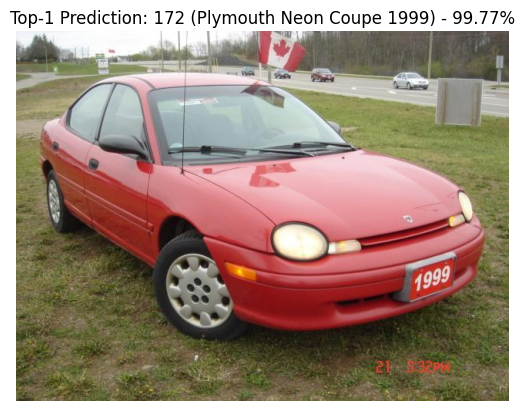


Top-5 Predictions:
172 - Plymouth Neon Coupe 1999: 99.77%
98 - Eagle Talon Hatchback 1998: 0.20%
6 - Acura Integra Type R 2001: 0.02%
171 - Nissan 240SX Coupe 1998: 0.00%
123 - Geo Metro Convertible 1993: 0.00%
time: 19.9 s (started: 2025-03-20 18:32:27 +00:00)


In [ ]:

# =============================
# UPLOAD IMAGE AND PERFORM INFERENCE
# =============================
print("\nUpload an image for inference...")
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

# Preprocess the uploaded image
image = load_img(image_path, target_size=IMG_SIZE)
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
image = train_datagen.standardize(image)

# Perform prediction
predictions = model.predict(image)

# Extract Top-5 Predictions
top_5_indices = np.argsort(predictions[0])[-5:][::-1]
top_5_classes = [(i, index_to_class[i], class_mapping_excel[int(index_to_class[i])], predictions[0][i]) for i in top_5_indices]

top_1_class = top_5_classes[0]

# Display Results
img = load_img(image_path)
plt.imshow(img)
plt.axis("off")
plt.title(f"Top-1 Prediction: {top_1_class[1]} ({top_1_class[2]}) - {top_1_class[3]*100:.2f}%")
plt.show()

print("\nTop-5 Predictions:")
for cls_num, cls_idx, cls_name, prob in top_5_classes:
    print(f"{cls_idx} - {cls_name}: {prob*100:.2f}%")


**SECTION 7: UPLOAD CNN MODEL** *End_to_End_Cnn*


---



In [ ]:
# =============================
# LOAD End_to_End_Cnn imitate Resnet-50 MODEL
# =============================
GDRIVE_MODEL_ID = "1R-xHabqKAbZn7aFi4fhFBIvHhHHl515Z"
MODEL_FILENAME = "car_classification_third_model.h5"
if not os.path.exists(MODEL_FILENAME):
    print("Downloading trained model...")
    !gdown --id {GDRIVE_MODEL_ID} -O {MODEL_FILENAME}

model = load_model(MODEL_FILENAME)
print("Model Loaded Successfully!")


Model Loaded Successfully!
time: 872 ms (started: 2025-03-20 18:32:50 +00:00)


**SECTION 8 : UPLOAD E IMAGES OF CARS AND RUN IT IN THE CNN MODEL**

 Model Loaded Successfully!

 Upload 3 images for inference...


Saving 00001.jpg to 00001 (5).jpg
Saving 00017.jpg to 00017 (8).jpg
Saving 00411.jpg to 00411 (4).jpg

 Processing image: 00001 (5).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

 Top-5 Predictions (Class Numbers Only):
57 | 58 | 39 | 148 | 88

 Processing image: 00017 (8).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

 Top-5 Predictions (Class Numbers Only):
57 | 58 | 39 | 148 | 88

 Processing image: 00411 (4).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

 Top-5 Predictions (Class Numbers Only):
57 | 58 | 39 | 148 | 88


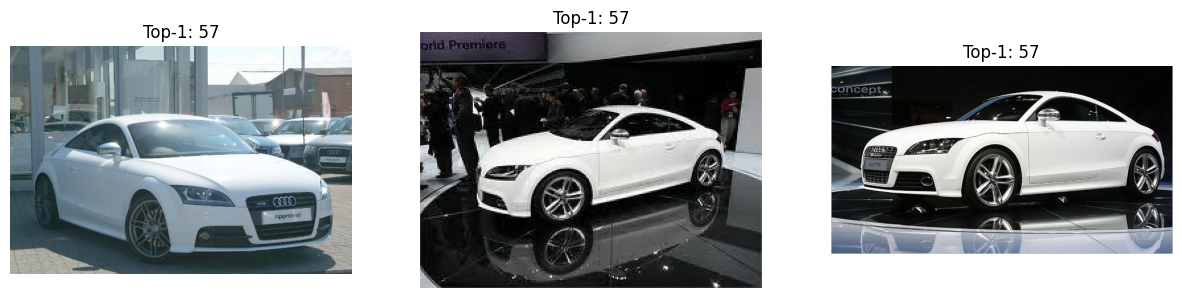

time: 15.8 s (started: 2025-03-20 18:32:54 +00:00)


In [ ]:
# =============================
# UPLOAD MULTIPLE IMAGES AND PERFORM INFERENCE
# =============================

import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from google.colab import files

# Load the trained model
MODEL_PATH = "/content/car_classification_third_model.h5"
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f" Model not found: {MODEL_PATH}")

model = load_model(MODEL_PATH)
print(" Model Loaded Successfully!")

# Define image properties
IMG_SIZE = (224, 224)

# Upload 3 images for inference
print("\n Upload 3 images for inference...")
uploaded = files.upload()
image_paths = list(uploaded.keys())[:3]  # Take only the first 3 images

# Create a figure to display images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, image_path in enumerate(image_paths):
    print(f"\n Processing image: {image_path}")

    # Preprocess the uploaded image (matching training preprocessing)
    image = load_img(image_path, target_size=IMG_SIZE)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)  # Add batch dimension

    # Normalize using the same ImageDataGenerator as during training
    image = image.astype("float32") / 255.0  # Normalization (like ImageDataGenerator)

    # Perform prediction
    predictions = model.predict(image)

    # Extract Top-5 Predictions
    top_5_indices = np.argsort(predictions[0])[-5:][::-1]

    # Get the top-1 prediction
    top_1_class = top_5_indices[0]

    # Display Results
    axes[idx].imshow(load_img(image_path))  # Show image
    axes[idx].axis("off")
    axes[idx].set_title(f"Top-1: {top_1_class}")

    print("\n Top-5 Predictions (Class Numbers Only):")
    print(" | ".join(str(cls_num) for cls_num in top_5_indices))

# Show all images in one figure
plt.show()


**SECTION 9 : image retrival load Embedding env**

In [ ]:
import os
import numpy as np
import pickle
import gdown
import matplotlib.pyplot as plt
from google.colab import files
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf

# ==============================
# Step 1: Define Paths and Google Drive IDs
# ==============================
MODEL_PATH = "/content/car_classification_model.h5"
TRAIN_FEATURES_PKL = "/content/train_embeddings.pkl"
TRAIN_FEATURES_NPY = "/content/train_features.npy"
TRAIN_LABELS_NPY = "/content/train_labels.npy"

# Google Drive File IDs
MODEL_FILE_ID = "1Df51xuRyJ2Vz9ZiwxBweTK3NUXwko2ZG"
FEATURES_PKL_FILE_ID = "19ytoBCvyD-MZrKn_vCaOcZEBbeohVBPx"
FEATURES_NPY_FILE_ID = "1fK91_65KzmlxOW3VQLjiRGE_3w6UUVhM"
LABELS_NPY_FILE_ID = "1Rh-CePTMveemvln-PS7XaEfAyI7GWwgw"

# ==============================
# Step 2: Download Necessary Files from Google Drive
# ==============================
print("Downloading model file...")
gdown.download(f"https://drive.google.com/uc?id={MODEL_FILE_ID}", MODEL_PATH, quiet=False)

print("Downloading train embeddings (Pickle)...")
gdown.download(f"https://drive.google.com/uc?id={FEATURES_PKL_FILE_ID}", TRAIN_FEATURES_PKL, quiet=False)

print("Downloading train features (NumPy)...")
gdown.download(f"https://drive.google.com/uc?id={FEATURES_NPY_FILE_ID}", TRAIN_FEATURES_NPY, quiet=False)

print("Downloading train labels (NumPy)...")
gdown.download(f"https://drive.google.com/uc?id={LABELS_NPY_FILE_ID}", TRAIN_LABELS_NPY, quiet=False)

# ==============================
# Step 3: Load Model & Embedding Extractor
# ==============================
custom_model = tf.keras.models.load_model(MODEL_PATH)
embedding_model = tf.keras.models.Model(inputs=custom_model.input, outputs=custom_model.output)

print("Model and embedding extractor loaded successfully!")

# ==============================
# Step 4: Load Extracted Features
# ==============================

# Load from Pickle
with open(TRAIN_FEATURES_PKL, "rb") as f:
    train_data = pickle.load(f)
train_features_pkl = train_data["features"]
train_labels_pkl = train_data["labels"]

# Load from NumPy files
train_features_npy = np.load(TRAIN_FEATURES_NPY)
train_labels_npy = np.load(TRAIN_LABELS_NPY)

print(f"Loaded train features from Pickle: {train_features_pkl.shape}")
print(f"Loaded train labels from Pickle: {len(train_labels_pkl)}")
print(f"Loaded train features from NumPy: {train_features_npy.shape}")
print(f"Loaded train labels from NumPy: {len(train_labels_npy)}")

# ==============================
# Step 5: Decide which dataset to use
# ==============================
# Use NumPy version as default, but keep Pickle as backup
train_features = train_features_npy if train_features_npy.shape == train_features_pkl.shape else train_features_pkl
train_labels = train_labels_npy if len(train_labels_npy) == len(train_labels_pkl) else train_labels_pkl

print(f"Final train features shape: {train_features.shape}")
print(f"Final train labels shape: {len(train_labels)}")



Downloading...
From (original): https://drive.google.com/uc?id=1Df51xuRyJ2Vz9ZiwxBweTK3NUXwko2ZG
From (redirected): https://drive.google.com/uc?id=1Df51xuRyJ2Vz9ZiwxBweTK3NUXwko2ZG&confirm=t&uuid=d8061eea-b50d-44b8-b9e1-62220f973736
To: /content/car_classification_model.h5
100%|██████████| 181M/181M [00:01<00:00, 131MB/s]


Downloading...
From: https://drive.google.com/uc?id=19ytoBCvyD-MZrKn_vCaOcZEBbeohVBPx
To: /content/train_embeddings.pkl
100%|██████████| 66.0M/66.0M [00:00<00:00, 129MB/s]


Downloading...
From: https://drive.google.com/uc?id=1fK91_65KzmlxOW3VQLjiRGE_3w6UUVhM
To: /content/train_features.npy
100%|██████████| 65.9M/65.9M [00:01<00:00, 34.9MB/s]


Downloading...
From: https://drive.google.com/uc?id=1Rh-CePTMveemvln-PS7XaEfAyI7GWwgw
To: /content/train_labels.npy
100%|██████████| 64.5k/64.5k [00:00<00:00, 2.46MB/s]


Model and embedding extractor loaded successfully!
Loaded train features from Pickle: (8044, 2048)
Loaded train labels from Pickle: 8044
Loaded train features from NumPy: (8044, 2048)
Loaded train labels from NumPy: 8044
Final train features shape: (8044, 2048)
Final train labels shape: 8044
time: 21.8 s (started: 2025-03-20 18:33:12 +00:00)


**SECTION 10 : UPLOAD IMAGE AND PERFORM IMAGE RETRIEVAL**

Loaded train features shape: (8044, 2048)
Loaded train labels shape: (8044,)

Upload an image for class prediction...


Saving 00016.jpg to 00016 (3).jpg


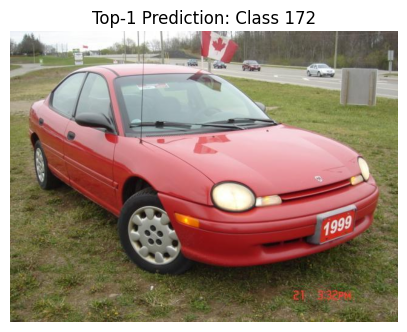


Predicted Class Results:
Top-1 Predicted Class: 172
Top-5 Predicted Classes:
172, 188, 159, 171, 188
time: 30.9 s (started: 2025-03-20 18:38:24 +00:00)


In [ ]:
import os
import numpy as np
import pickle
import gdown
import matplotlib.pyplot as plt
from google.colab import files
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf

# ==============================
# Step 1: Load Pretrained Model for Embeddings
# ==============================
# Ensure that the embedding model is identical to the one used for training
embedding_model = tf.keras.applications.ResNet50(weights="imagenet", include_top=False, pooling="avg")

# ==============================
# Step 2: Load Train Features and Labels
# ==============================
train_features = np.load("/content/train_features.npy")  # Should have shape (num_samples, 2048)
train_labels = np.load("/content/train_labels.npy")      # Should have shape (num_samples,)

print(f"Loaded train features shape: {train_features.shape}")  # Ensure (8044, 2048)
print(f"Loaded train labels shape: {train_labels.shape}")  # Ensure (8044,)

# ==============================
# Step 3: Preprocess Image
# ==============================
IMG_SIZE = (224, 224)

def preprocess_image(image_path):
    """Loads, resizes, and normalizes an image for embedding extraction."""
    image = load_img(image_path, target_size=IMG_SIZE)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image

# ==============================
# Step 4: Upload Image & Perform KNN Retrieval
# ==============================
def retrieve_similar_classes():
    """Uploads an image, extracts features, and finds the closest class matches using KNN."""
    print("\nUpload an image for class prediction...")
    uploaded = files.upload()
    image_path = list(uploaded.keys())[0]

    # Preprocess Image
    image = preprocess_image(image_path)
    if image is None:
        print("Error processing uploaded image!")
        return

    # Extract Features using ResNet50 with pooling='avg' (2048 features)
    query_features = embedding_model.predict(image, verbose=0).flatten()

    # Verify that query features have 2048 dimensions
    if query_features.shape[0] != 2048:
        print(f"Error: Extracted features have {query_features.shape[0]} dimensions instead of 2048!")
        return

    # Train KNN Model (k=5)
    knn = KNeighborsClassifier(n_neighbors=5, metric="euclidean")
    knn.fit(train_features, train_labels)

    # Get Nearest Neighbors
    distances, indices = knn.kneighbors([query_features])

    # Extract Top-5 Class Predictions (Adding +1 to each class)
    top_5_classes = [train_labels[i] + 1 for i in indices[0]]

    # Extract Top-1 Class Prediction (Adding +1)
    top_1_class = top_5_classes[0]

    # ==============================
    # Display the Uploaded Image
    # ==============================
    plt.figure(figsize=(5, 5))
    plt.imshow(load_img(image_path))
    plt.axis("off")
    plt.title(f"Top-1 Prediction: Class {top_1_class}")
    plt.show()

    # ==============================
    # Print Results
    # ==============================
    print("\nPredicted Class Results:")
    print(f"Top-1 Predicted Class: {top_1_class}")
    print("Top-5 Predicted Classes:")
    print(", ".join(map(str, top_5_classes)))

# Run Class Prediction
retrieve_similar_classes()
